# Importing libraries and data

In [42]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
import nasdaqdatalink
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [7]:
quandl.ApiConfig.api_key = 'qddxWkBpL7_u5hg9vfS6'

In [70]:
# Set your API key
nasdaqdatalink.ApiConfig.api_key = 'qddxWkBpL7_u5hg9vfS6'

# Fetch data using the API
def fetch_data(datatable_code, **filters):
    try:
        data = nasdaqdatalink.get_table(datatable_code, **filters)
        return pd.DataFrame(data)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Fetch data for specific indicator_id and region_id
datatable_code = 'ZILLOW/DATA'
filters = {
    'indicator_id': 'ZSFH',
    'region_id': '99999'
}

df = fetch_data(datatable_code, **filters)



In [11]:
df.head(5)

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2024-06-30,481540.769792
1,ZSFH,99999,2024-05-31,480258.243144
2,ZSFH,99999,2024-04-30,477462.034343
3,ZSFH,99999,2024-03-31,476120.204987
4,ZSFH,99999,2024-02-29,476598.175844


In [12]:
df.shape

(234, 4)

In [14]:
df.info

<bound method DataFrame.info of      indicator_id region_id       date          value
None                                                 
0            ZSFH     99999 2024-06-30  481540.769792
1            ZSFH     99999 2024-05-31  480258.243144
2            ZSFH     99999 2024-04-30  477462.034343
3            ZSFH     99999 2024-03-31  476120.204987
4            ZSFH     99999 2024-02-29  476598.175844
...           ...       ...        ...            ...
229          ZSFH     99999 2005-05-31  169868.000000
230          ZSFH     99999 2005-04-30  167105.000000
231          ZSFH     99999 2005-03-31  165721.000000
232          ZSFH     99999 2005-02-28  164998.000000
233          ZSFH     99999 2005-01-31  164988.000000

[234 rows x 4 columns]>

In [16]:
# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

In [17]:
# Set 'date' as the index
df.set_index('date', inplace=True)

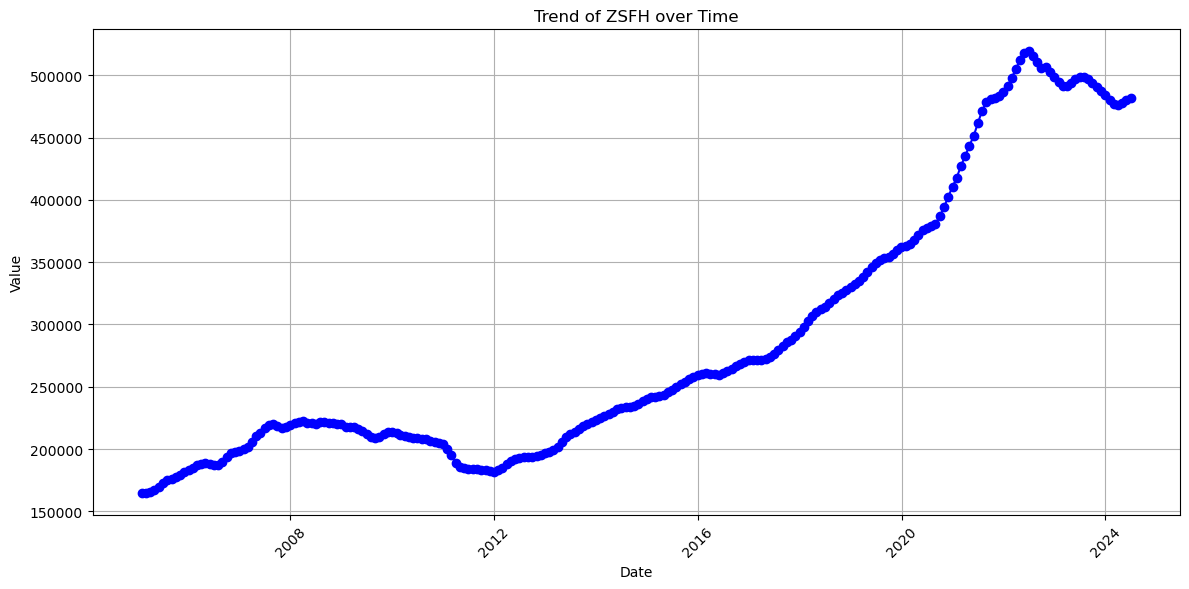

In [18]:
# Plot the data to visualize trends
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['value'], marker='o', linestyle='-', color='b')
plt.title('Trend of ZSFH over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Wrangling, subsetting and cleaning time series data

In [21]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 indicator_id    0
region_id       0
value           0
dtype: int64


In [23]:
df.sort_index(inplace=True)

In [30]:
#Subsetting the data: Filter for a specific date range
start_date = '2020-06-30'
end_date = '2024-06-30'
df_subset = df.loc[start_date:end_date]

In [31]:
print("Data types:\n", df_subset.dtypes)


Data types:
 indicator_id     object
region_id        object
value           float64
dtype: object


In [27]:
#remove duplicates
df.drop_duplicates(inplace=True)

In [32]:
print("Summary statistics:\n", df_subset.describe())

Summary statistics:
                value
count      49.000000
mean   471841.282249
std     40179.989881
min    377427.635383
25%    461294.473444
50%    484211.063642
75%    497701.319069
max    519130.327859


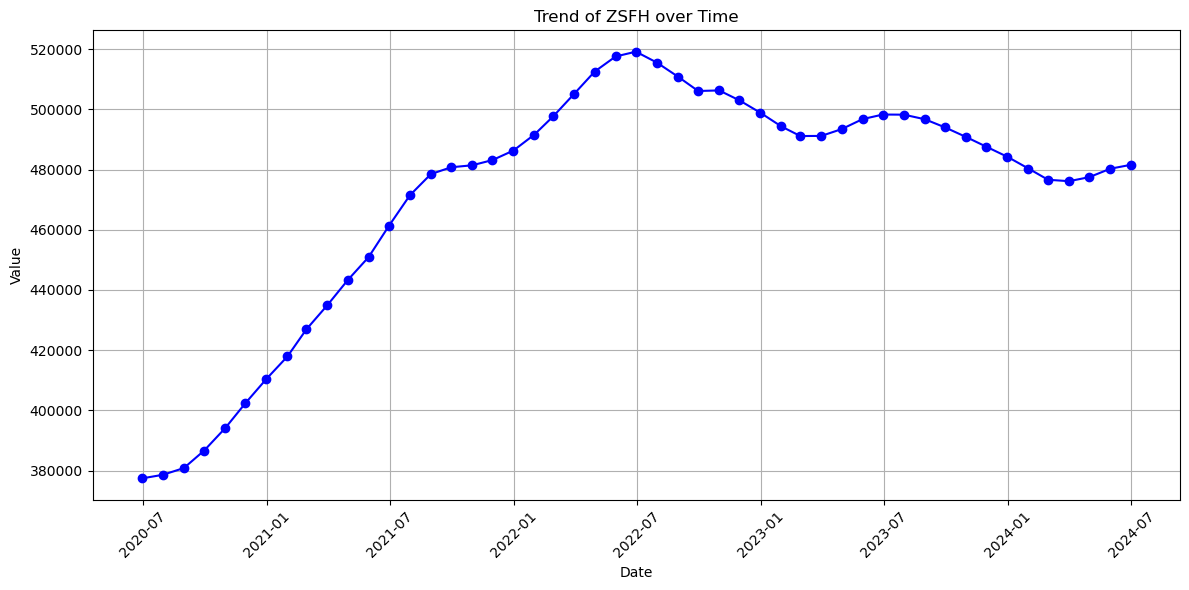

In [33]:
# Ploting the data to visualize trends
plt.figure(figsize=(12, 6))
plt.plot(df_subset.index, df_subset['value'], marker='o', linestyle='-', color='b')
plt.title('Trend of ZSFH over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

In [36]:
# Decomposing the time series (additive model)
result = seasonal_decompose(df_subset['value'], model='additive', period=1)

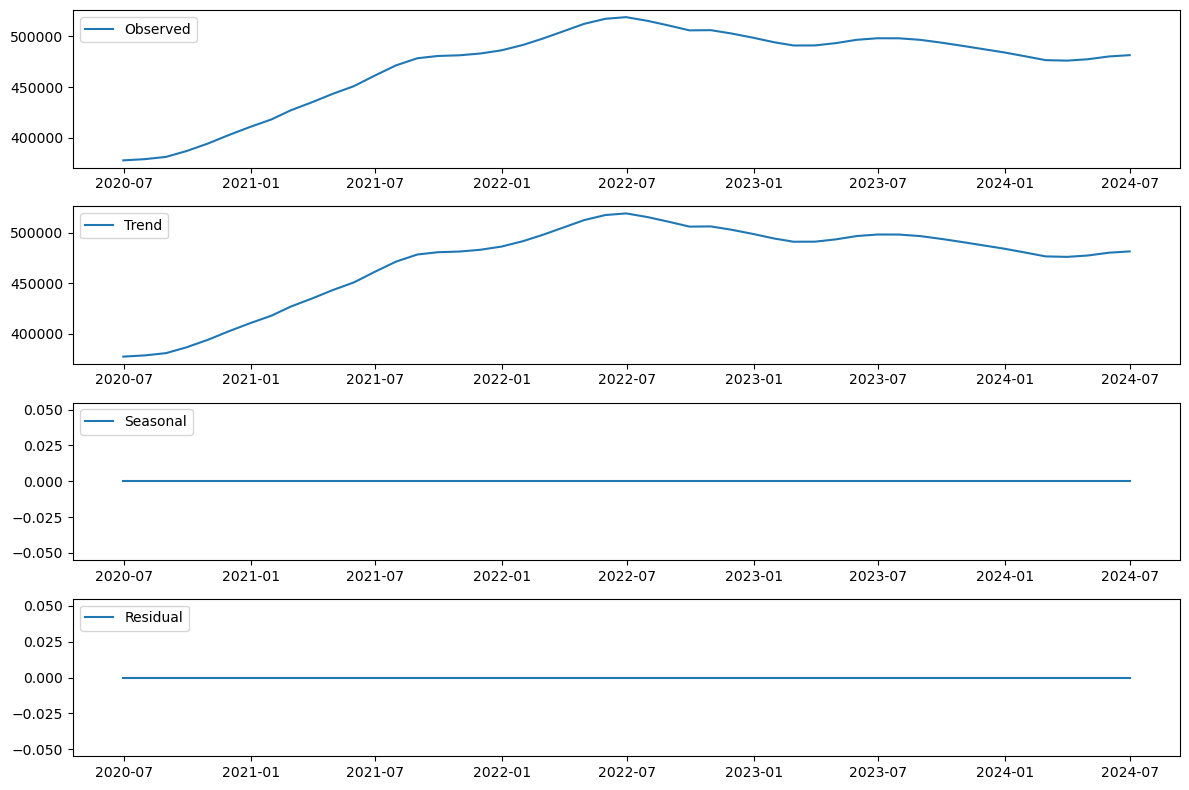

In [37]:
# Plotting the decomposed components
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

**Analysis**

The time series data primarily shows a long-term upward trend peaking around mid-2022, followed by a slight decline and stabilization. There are no significant seasonal patterns or residual variations detected, indicating the data's variation is predominantly explained by the trend.

# Dickey-Fuller test to check for stationarity

In [44]:
# Perform the Dickey-Fuller test
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

# Perform the test on the value column.
adf_test(df_subset['value'])

Results of Dickey-Fuller Test:
Test Statistic                 -2.906002
p-value                         0.044654
#Lags Used                      4.000000
Number of Observations Used    44.000000
Critical Value (1%)            -3.588573
Critical Value (5%)            -2.929886
Critical Value (10%)           -2.603185
dtype: float64


**Analysis**

The time series is stationary at the 5% and 10% significance levels but not at the 1% level. Given the p-value is less than 0.05, we can reasonably conclude that the time series is stationary.

# Check Data Autocorrelations.

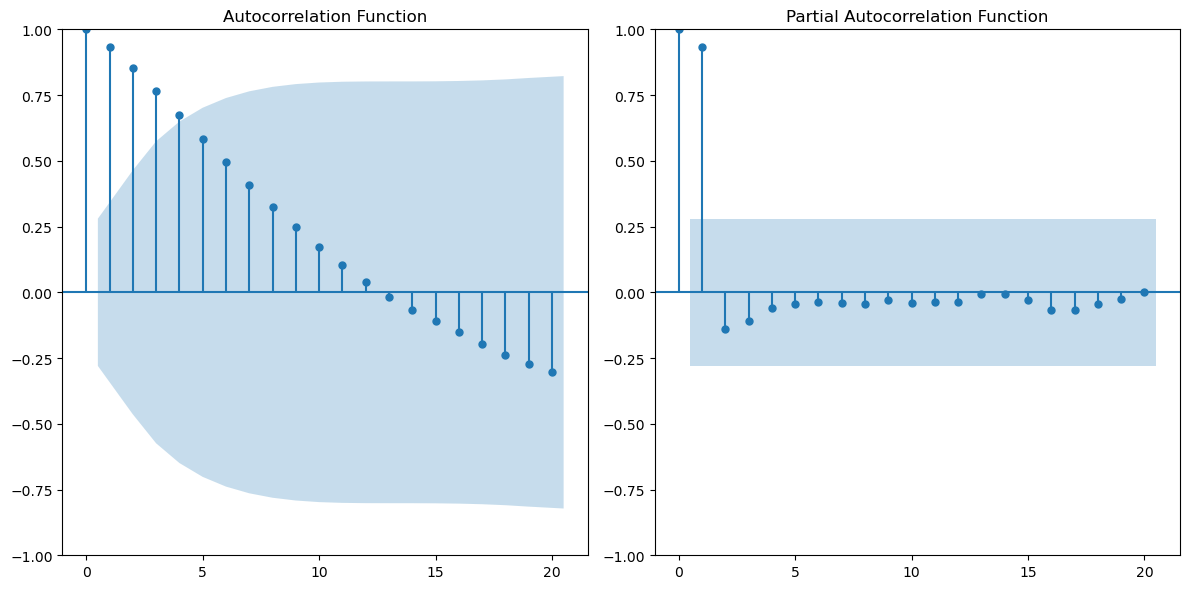

In [49]:
# Importing plot_acf and plot_pacf for the autocorrelation and partial correlation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

# Plotting ACF and PACF
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(df_subset['value'], ax=plt.gca(), lags=20)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(df_subset['value'], ax=plt.gca(), lags=20)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

**Analysis**

The ACF plot indicates significant autocorrelations at the first few lags, suggesting a strong trend component in the time series. The PACF plot shows a sharp cutoff after the first lag, indicating an AR(1) model may be suitable. Overall, the ACF and PACF patterns suggest the time series is non-stationary with a trend, aligning with the Dickey-Fuller test results.

# Bonus Task

In [54]:
data_diff = df_subset['value'] - df_subset['value'].shift(1)
data_diff = data_diff.dropna()


In [56]:
data_diff.head(5)

date
2020-07-31    1195.586290
2020-08-31    2241.019194
2020-09-30    5818.501415
2020-10-31    7433.278146
2020-11-30    8323.250327
Name: value, dtype: float64

In [59]:
data_diff_df = data_diff.to_frame(name='value_diff')


In [63]:
data_diff_df.columns

Index(['value_diff'], dtype='object')

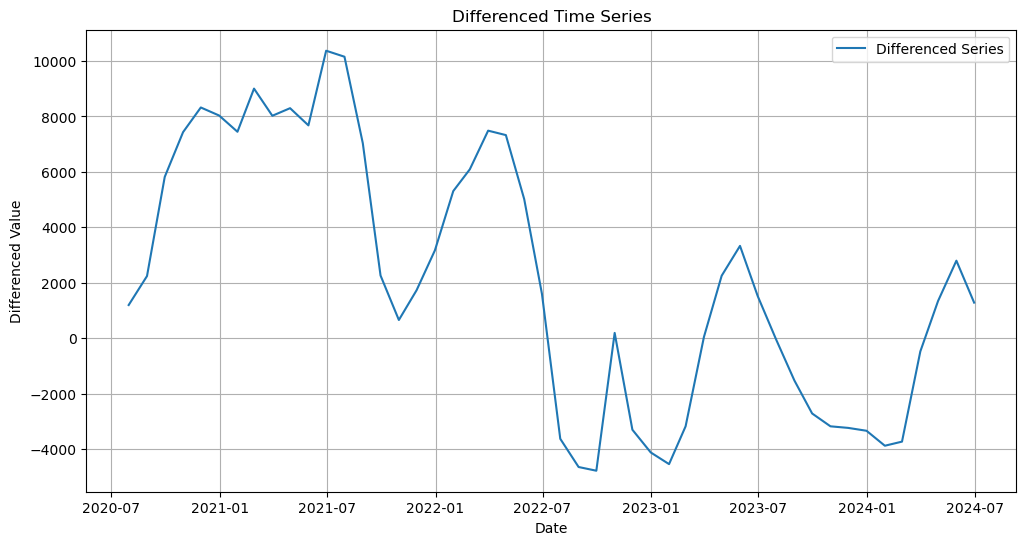

In [64]:
# Plotting the differenced time series
plt.figure(figsize=(12, 6))
plt.plot(data_diff, label='Differenced Series')
plt.title('Differenced Time Series')
plt.xlabel('Date')
plt.ylabel('Differenced Value')
plt.legend()
plt.grid(True)
plt.show()


In [66]:
data_diff

date
2020-07-31     1195.586290
2020-08-31     2241.019194
2020-09-30     5818.501415
2020-10-31     7433.278146
2020-11-30     8323.250327
2020-12-31     8033.254123
2021-01-31     7446.961575
2021-02-28     9004.174244
2021-03-31     8024.370758
2021-04-30     8297.692628
2021-05-31     7677.796297
2021-06-30    10370.953064
2021-07-31    10154.410269
2021-08-31     7034.226745
2021-09-30     2261.399759
2021-10-31      656.236524
2021-11-30     1731.073379
2021-12-31     3170.958361
2022-01-31     5306.337773
2022-02-28     6092.202815
2022-03-31     7486.954450
2022-04-30     7326.831902
2022-05-31     5016.506596
2022-06-30     1598.715841
2022-07-31    -3630.400311
2022-08-31    -4648.112449
2022-09-30    -4781.995785
2022-10-31      189.467809
2022-11-30    -3303.533125
2022-12-31    -4122.277214
2023-01-31    -4543.773304
2023-02-28    -3178.861305
2023-03-31       44.340607
2023-04-30     2253.214777
2023-05-31     3330.083446
2023-06-30     1516.618721
2023-07-31      -43.154

**Observation**

The differenced time series CPI_diff shows significant variability and large fluctuations, indicating it may have achieved stationarity. If confirmed by the Dickey-Fuller test, this series is suitable for further time series modeling, such as ARIMA, where differencing stabilizes the mean.

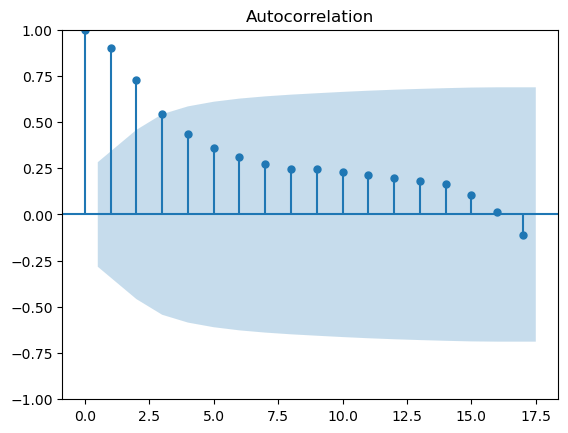

In [69]:
plot_acf(data_diff)
plt.show()

**Observation**

The ACF plot for the differenced CPI_diff series shows significant autocorrelations at the first few lags, followed by a gradual decline, with most autocorrelations falling within the confidence interval at higher lags. This suggests that the differencing has likely helped achieve stationarity, and the series is now suitable for further time series modeling, such as ARIMA.